In [1]:
%matplotlib notebook

In [2]:
from os import cpu_count
import numpy as np
from compound_prism_designer import optimize, PyGlass, OptimizerSpecification, CompoundPrismSpecification, \
    GaussianBeamSpecification, DetectorArraySpecification, PyDesign
import matplotlib.pyplot as plt
import toml

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
deviation_cmap = mpl.cm.ScalarMappable(mpl.colors.Normalize(0, 90, clip=True), 'PuRd')

In [4]:
opt_spec = OptimizerSpecification(
    iteration_count=150,
    population_size=256,
    offspring_size=128,
    crossover_distribution_index=20,
    mutation_distribution_index=20,
    mutation_probability=0.05,
    seed=12345,
    epsilons=(5.0, 0.05, 0.05)
)

cmpnd_spec = CompoundPrismSpecification(
    max_count=6,
    max_height=30,
    width=7,
)

beam_spec = GaussianBeamSpecification(
    width=1.8,
    wavelength_range=(0.5, 0.82)
)

detarr_spec = DetectorArraySpecification(
    length=32,
    max_incident_angle=45,
    bounds=[(i + 0.1, i + 0.9) for i in range(32)]
)

In [5]:
designs = optimize(None, opt_spec, cmpnd_spec, beam_spec, detarr_spec)

<IPython.core.display.Javascript object>


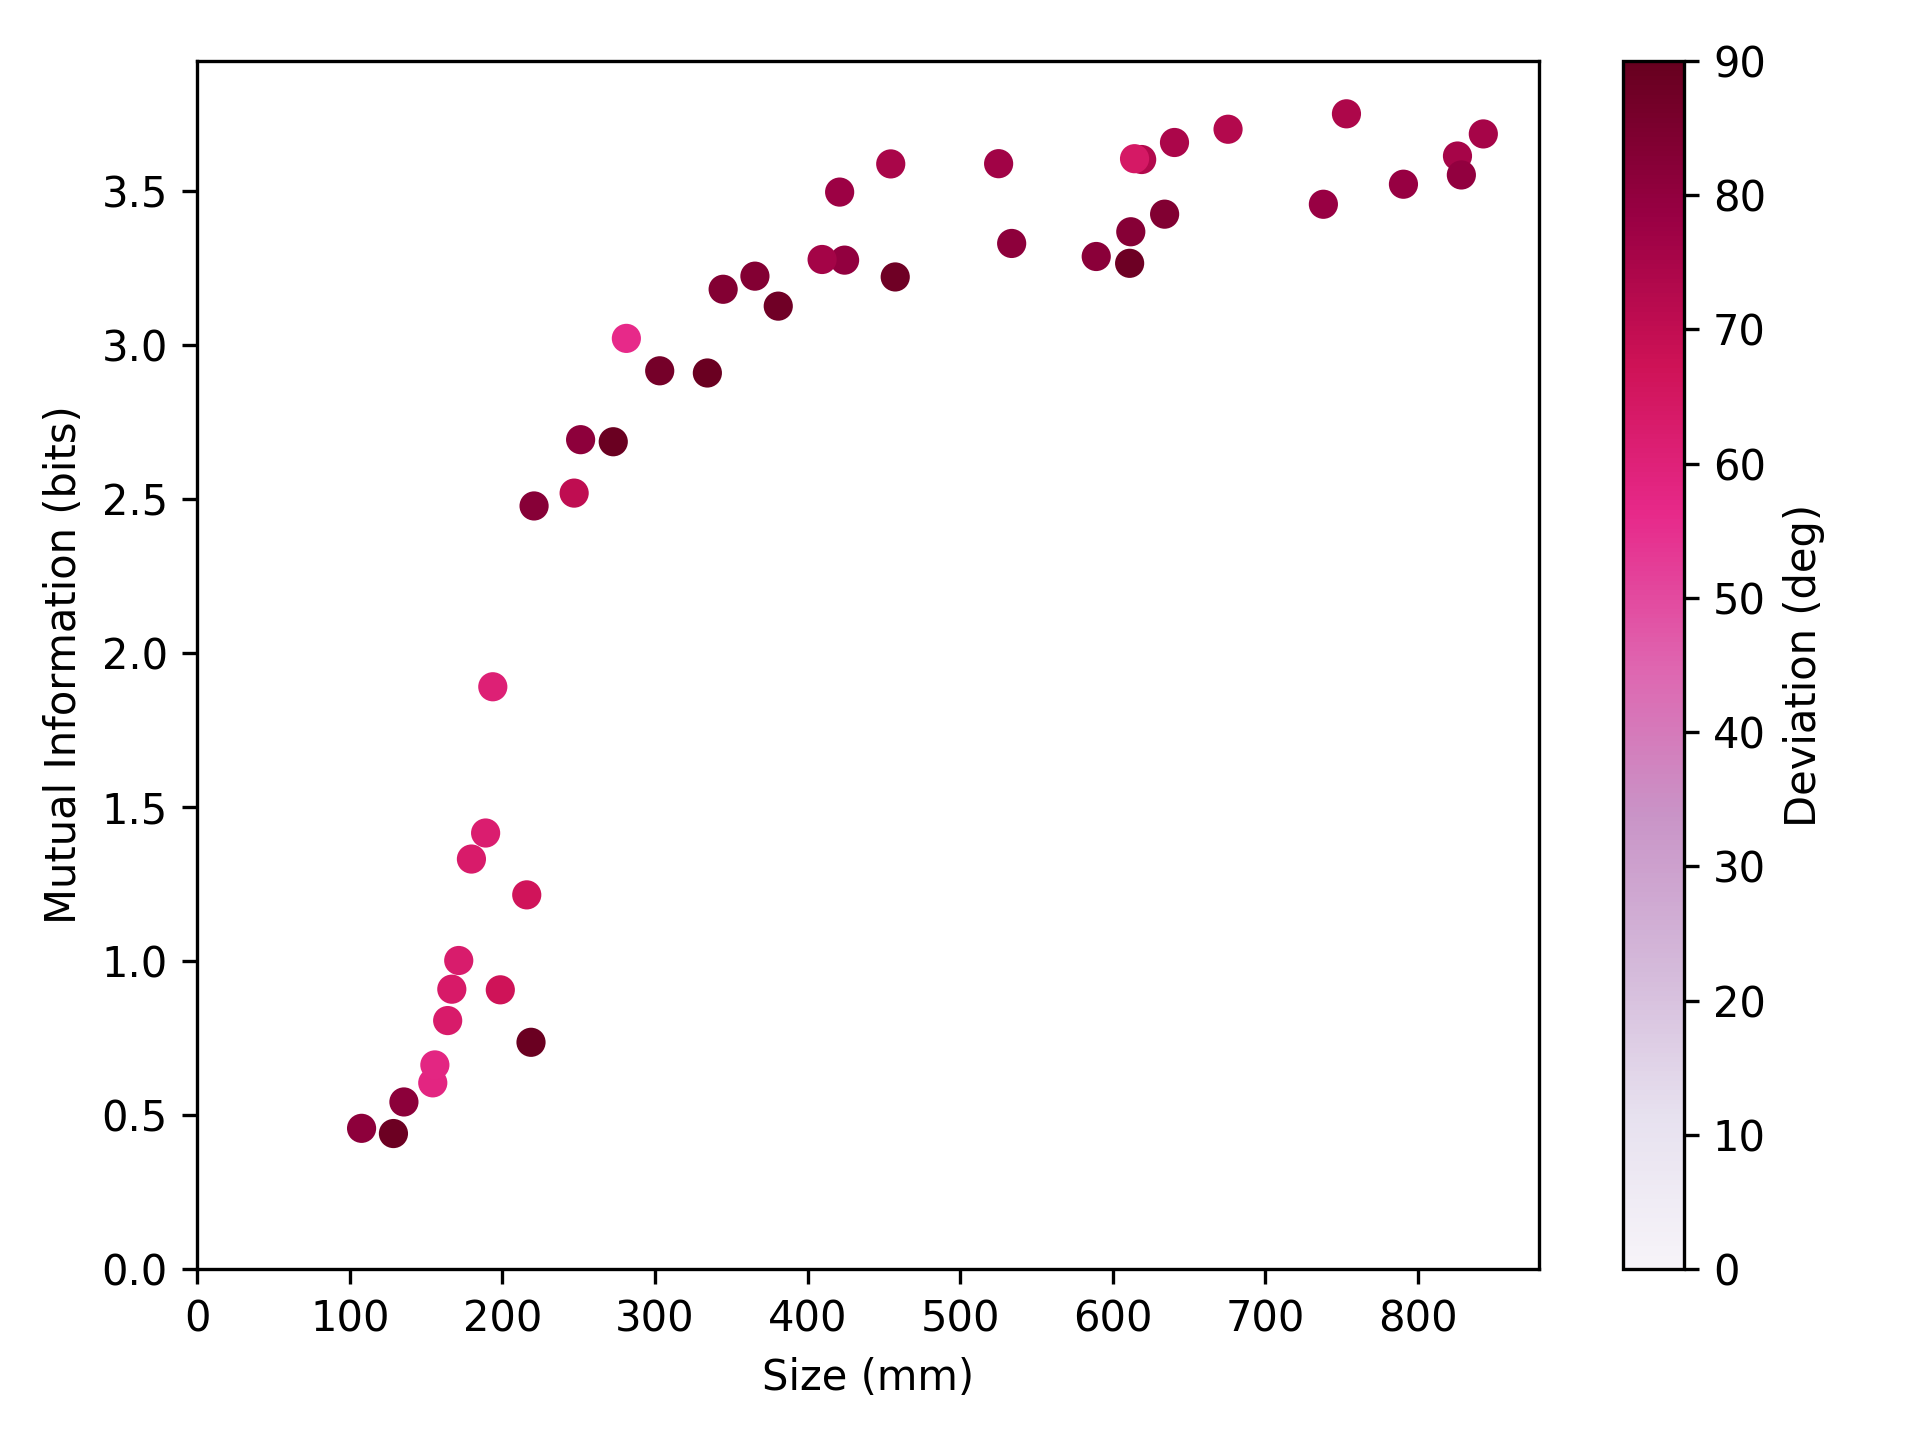

In [8]:
x, y, c = np.array([(design.fitness.size, design.fitness.info, np.rad2deg(np.arccos(design.fitness.deviation))) for design in designs]).T
plt.scatter(x, y, c=c, norm=deviation_cmap.norm, cmap=deviation_cmap.cmap)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel("Size (mm)")
plt.ylabel("Mutual Information (bits)")
clb = plt.colorbar(deviation_cmap)
clb.set_label("Deviation (deg)")
plt.tight_layout()

In [4]:
units = "mm"
config = Config(
    max_prism_count=6,
    max_prism_height=30,
    prism_width=7,
    beam_width=1.8,
    wavelength_range=(0.5, 0.82),
    detector_array_length=32,
    detector_array_min_ci=np.cos(np.deg2rad(45)),
    detector_array_bin_bounds=np.array(
        [(i + 0.1, i + 0.9) for i in range(32)]),
    glass_catalog=catalog
)

In [5]:
iter_count = 200
thread_count = 64
# thread_count = cpu_count()
pop_size = 120

In [ ]:
from platypus.algorithms import *
from platypus import experiment, ProcessPoolEvaluator, Hypervolume
problem = PlatypusPrismProblem(config)

epsilons = 0.1, 0.05, 0.05

algorithms = [NSGAII,
              (NSGAIII, {"divisions_outer":12}),
              (CMAES, {"epsilons": epsilons}),
              # GDE3,
              # IBEA,
              (MOEAD, {"weight_generator":normal_boundary_weights, "divisions_outer":12}),
              (OMOPSO, {"epsilons": epsilons}),
              SMPSO,
              SPEA2,
              (EpsMOEA, {"epsilons": epsilons})]

with ProcessPoolEvaluator() as evaluator:
    results = experiment(algorithms, problem, nfe=100000, seeds=10, evaluator=evaluator)

In [ ]:
# display the results
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(24, 12))

hyp = Hypervolume(minimum=[0,-np.log2(len(config.detector_array_bin_bounds)),0], maximum=[1000,0,1])

for i, algorithm in enumerate(results.keys()):
    result = results[algorithm]["PlatypusPrismProblem"][0]
    print(algorithm, hyp(result))

    ax = fig.add_subplot(2, 4, i+1)
    x, y, c = np.array([s.objectives for s in result]).T
    c = np.rad2deg(np.arcsin(c))
    sc = ax.scatter(x, y, c=c, cmap='viridis')
    clb = fig.colorbar(sc)
    ax.set_title(algorithm)
    clb.ax.set_ylabel("deviation (deg)")
    ax.set_xlabel(f"size ({units})")
    ax.set_ylabel("mutual information (bits)")

plt.show()

In [ ]:
solutions = use_pygmo(iter_count, thread_count, pop_size, config)
len(solutions)

In [ ]:
[s for s in solutions if s.fitness.info > 2]

In [ ]:
def show_interactive(config: Config, solns: [Soln], units: str):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    nrows, ncols = 2, 4
    objectives_plt = fig.add_subplot(1, ncols, 1)

    x, y, c = np.array([(soln.fitness.size, soln.fitness.info, soln.fitness.deviation)
                        for soln in solns]).T
    c = np.rad2deg(np.arcsin(c))

    sc = objectives_plt.scatter(x, y, c=c, cmap="viridis", picker=True)
    clb = fig.colorbar(sc)
    clb.ax.set_ylabel("deviation (deg)")
    objectives_plt.set_xlabel(f"size ({units})")
    objectives_plt.set_ylabel("mutual information (bits)")
    # ax.set_zlabel("deviation (deg)")
    """
    x, y, z, c = res.T
    c = 1 - c

    sc = ax.scatter(x, y, z, c=c, cmap="viridis", picker=True)
    clb = fig.colorbar(sc)
    clb.ax.set_ylabel('transmittance')
    """
    prism_plt = fig.add_subplot(nrows, ncols, 2)
    text_ax = fig.add_subplot(nrows, ncols, 6)
    det_plt = fig.add_subplot(nrows, ncols, 3)
    trans_plt = fig.add_subplot(nrows, ncols, 7)
    violin_plt = fig.add_subplot(1, ncols, 4)
    prism_plt.axis('off')
    text_ax.axis('off')

    def pick(event):
        soln = sorted((solns[i] for i in event.ind), key=lambda s: -s.fitness.info)[0]
        prism = soln.compound_prism
        detarr = soln.detector_array
        beam = soln.beam
        size, info, dev = soln.fitness.size, soln.fitness.info, soln.fitness.deviation

        det_arr_pos, det_arr_dir = det = detector_array_position(prism, detarr, beam)
        det_arr_end = det_arr_pos + det_arr_dir * config.detector_array_length

        midpt = list(midpts_gen(prism))[-1]
        detarr_offset = (det_arr_pos + det_arr_dir * config.detector_array_length / 2) - midpt

        draw_compound_prism(prism_plt, prism)
        spectro = plt.Polygon((det_arr_pos, det_arr_end), closed=None, fill=None, edgecolor='k')
        prism_plt.add_patch(spectro)

        wmin, wmax = config.wavelength_range
        for w, color in zip((wmin, (wmin + wmax) / 2, wmax), ('r', 'g', 'b')):
            for y in (beam.y_mean - config.beam_width, beam.y_mean, beam.y_mean + config.beam_width):
                try:
                    ray = np.stack(tuple(trace(w, y, prism, detarr, det)), axis=0)
                    poly = plt.Polygon(ray, closed=None, fill=None, edgecolor=color)
                    prism_plt.add_patch(poly)
                except RayTraceError:
                    pass

        prism_plt.axis('scaled')
        prism_plt.axis('off')

        display = f"""CompoundPrism ({', '.join(g.name for g in prism.glasses)})
    Parameters:
        height ({units}): {prism.height:.4}
        angles (deg): {', '.join(f'{np.rad2deg(angle):.4}' for angle in prism.angles)}
        lengths ({units}): {', '.join(f'{l:.4}' for l in prism.lengths)}
        y_mean ({units}): {beam.y_mean:.4}
        curvature: {prism.curvature:.4}
        detector array angle (deg): {np.rad2deg(detarr.angle):.4}
        objectives: (size={size:.4} ({units}), info: {info:.4} (bits), deviation: {np.rad2deg(np.arcsin(dev)):.4} (deg))
"""
        zemax_design, zemax_file = create_zmx(prism, detarr, beam, detarr_offset)
        display += zemax_design
        print(display)
        with open("spec.zmx", "w") as f:
            f.write(zemax_file)
        text_ax.cla()
        text_ax.text(0, 0.5, display, horizontalalignment='left', verticalalignment='center',
                     transform=text_ax.transAxes)
        text_ax.axis('scaled')
        text_ax.axis('off')

        det_plt.clear()
        trans_plt.cla()
        violin_plt.cla()

        waves = np.linspace(config.wavelength_range[0], config.wavelength_range[1], 100)
        ts = TransmissionData(waves, prism, detarr, beam, det)
        p_det = ts.sum(axis=1) * (1 / len(waves))
        p_w_l_D = ts.sum(axis=0)
        vpstats = [
            {
                "coords": waves,
                "vals": t,
                "mean": None,
                "median": None,
                "min": None,
                "max": None,
            }
            for t in ts
        ]
        parts = violin_plt.violin(vpstats, showextrema=False, widths=1)
        for pc in parts['bodies']:
            pc.set_facecolor('black')
        violin_plt.plot([1, len(p_det)], config.wavelength_range, 'k--')
        det_plt.scatter(1 + np.arange(len(p_det)), p_det * 100, color='k')
        trans_plt.plot(waves, p_w_l_D * 100, 'k')
        trans_plt.axhline(np.mean(p_w_l_D) * 100, color='k', linestyle='--')

        det_plt.set_xlabel("detector bins")
        trans_plt.set_xlabel("wavelength (μm)")
        violin_plt.set_xlabel("detector bins")
        det_plt.set_ylabel("p (%)")
        trans_plt.set_ylabel("p (%)")
        violin_plt.set_ylabel("wavelength (μm)")
        det_plt.set_title("p(D=d|Λ)")
        trans_plt.set_title("p(D|Λ=λ)")
        violin_plt.set_title("p(D=d|Λ=λ) as a Pseudo Violin Plot")
        trans_plt.set_ylim(0, 100)
        det_plt.set_ylim(bottom=0)

        fig.canvas.draw()
        fig.canvas.flush_events()

    fig.canvas.mpl_connect('pick_event', pick)

    # plt.show()
    return fig

In [ ]:
%matplotlib qt

show_interactive(config, solutions, units)